# Lab 3: Policy Search
## Task
Write agents able to play Nim, with an arbitrary number of rows and an upper bound  on the number of objects that can be removed in a turn (a.k.a., subtraction game).

The player taking the last object wins.

- Task3.1: An agent using fixed rules based on nim-sum (i.e., an expert system)

- Task3.2: An agent using evolved rules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from itertools import accumulate
from operator import xor
import random


ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

Nimply = namedtuple("Nimply", "row, num_objects")

## Class NIM

In [15]:
class Nim:
    # Initialize a board for NIM game with k rows 
    # (the rows have odds increasing numbers starting from 1)
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    # Remove from a choosen row a selected number of objects
    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

    def get_state_and_reward(self):
        return self.rows, 0 if self else 1


In [3]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result

def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)
    cooked["active_obj_number"] = sum(c for r, c in enumerate(state.rows))

    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

## RLA Agent

In [16]:
class Agent(object):
    def __init__(self, alpha=0.1, random_factor=0.2):  # 80% explore, 20% exploit 

        self.state_history = []  
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}

    def choose_action(self, state: Nim):
        data = cook_status(state)
        moves = data["possible_moves"]
        found_next = 0

        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
            num_objects = random.randint(1, state.rows[row])
            next_move = Nimply(row, num_objects)

            new_state = deepcopy(state)
            new_state.nimming(next_move)

            if tuple(new_state._rows) not in self.G:
                self.G[tuple(new_state._rows)] = np.random.uniform(low=1.0, high=0.1)
        else:
            for m in moves:

                new_state = deepcopy(state)
                new_state.nimming(m)

                if tuple(new_state._rows) not in self.G:
                    self.G[tuple(new_state._rows)] = np.random.uniform(low=1.0, high=0.1)

                if self.G[tuple(new_state._rows)] >= maxG:
                    next_move = m
                    maxG = self.G[tuple(new_state._rows)]
                    found_next = 1
                
            if found_next == 0:
                next_move = random.choice(moves)
        
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] += self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []
        self.random_factor -= 10e-5  # decrease random factor each episode of play

## Main

In [5]:
def pure_random(state: Nim) -> Nimply:
    # enumerate(state.rows) --> return the number of the row (r) and the number of objects in that row (c)
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [6]:
def dumb_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    row = data["longest_row"]
    num_objects = 1
    return Nimply(row, num_objects)

status: Initial board  ---> <1 3 5 7 9 11 13 15 17 19>
matches: 1 - wins: 1
matches: 51 - wins: 24
matches: 101 - wins: 26
matches: 151 - wins: 25
matches: 201 - wins: 22
matches: 251 - wins: 25
matches: 301 - wins: 28
matches: 351 - wins: 37
matches: 401 - wins: 24
matches: 451 - wins: 27
matches: 501 - wins: 28
matches: 551 - wins: 30
matches: 601 - wins: 26
matches: 651 - wins: 29
matches: 701 - wins: 33
matches: 751 - wins: 21
matches: 801 - wins: 29
matches: 851 - wins: 31
matches: 901 - wins: 31
matches: 951 - wins: 27
matches: 1001 - wins: 27
matches: 1051 - wins: 26
matches: 1101 - wins: 26
matches: 1151 - wins: 33
matches: 1201 - wins: 29
matches: 1251 - wins: 30
matches: 1301 - wins: 34
matches: 1351 - wins: 22
matches: 1401 - wins: 32
matches: 1451 - wins: 35
matches: 1501 - wins: 30
matches: 1551 - wins: 31
matches: 1601 - wins: 32
matches: 1651 - wins: 33
matches: 1701 - wins: 34
matches: 1751 - wins: 34
matches: 1801 - wins: 38
matches: 1851 - wins: 34
matches: 1901 - win

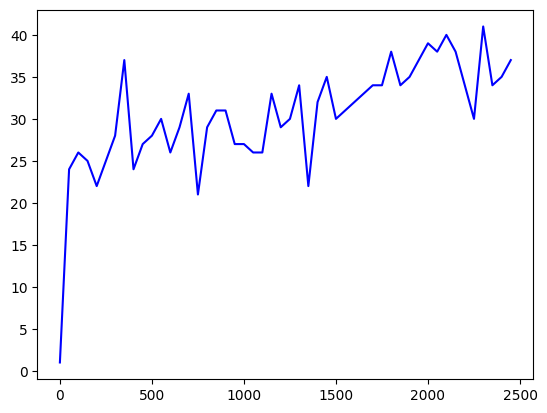

In [19]:
NIM_SIZE = 10

nim = Nim(NIM_SIZE)

agent = Agent(alpha=0.1, random_factor=0.25) # 0.1, 0.25
moveHistory = []
indices = []

counter = 0
tot_c = 0

print(f"status: Initial board  ---> {nim}")

for i in range(2500):
    win = 0

    while nim:
        # choose an action (explore or exploit)
        ply = agent.choose_action(nim)

        # update the maze according to the action
        nim.nimming(ply)

        # get the new state and reward
        state, reward = nim.get_state_and_reward() 

        # update the robot memory with state and reward
        agent.update_state_history(state, reward)

        # THE OPPONENT PLAYS
        if nim:
            ply = pure_random(nim)
            nim.nimming(ply)

            if not(nim):
                win = 1

    # agent should learn after every episode
    agent.learn()

    if win == 0: 
        counter += 1

    if i % 50 == 0:
        print(f"matches: {i+1} - wins: {counter}")
        moveHistory.append(counter)
        indices.append(i)
        tot_c += counter
        counter = 0

    # reinitialize the nim game
    nim = Nim(NIM_SIZE)  

print(f"Tot matches: {i+1} - Tot wins: {tot_c}")
print(moveHistory)
plt.plot(indices, moveHistory, "b")
plt.show()